In [2]:
%run vizFunc.py

# database path
db_path = config.get('statsbomb_db_path')

# create an sqlalchemy engine to connect to the SQLite database
engine = create_engine(f'sqlite:///{db_path}')

# instantiate a parser object
parser = Sbopen()

In [3]:
# RUN ONLY WHEN WORKING A DIFFERENT PLAYER/SEASON
# connect to the sqlite database
conn = sqlite3.connect(db_path)

with open('data/selected_matches.sql') as inserts:
    q1 = inserts.read()

# retrieve all matchdata
seasonId = 27 # only for reporting, change in .sql file
competitionId = 2
query = q1
print(query)
# use the connection and query to create a dataframe
matches = pd.read_sql_query(query, conn)

# close the connection
conn.close()

/* Retrieve all matches and lineups for the target season*/
SELECT m.*
	, l. player_id
	, l.player_name
	, l.player_nickname
	, l.jersey_number
	, l.team_id
	, l.team_name
	, l.country_id
	, l.country_name as country_name_lineup
FROM (
	SELECT *
	FROM MATCH m
	WHERE 1=1
	AND  season_id = 27
	AND competition_id = 2 -- if it's necessary to see the picture regardless the competition through the season, just comment out.
	)  m
LEFT JOIN lineup l
ON m.match_id = l.match_id




In [6]:
# RUN ONLY WHEN WORKING A DIFFERENT PLAYER/SEASON
matches.head()
match_list = matches.match_id.unique().tolist()

In [8]:
%%time 
# RUN ONLY WHEN WORKING A DIFFERENT PLAYER-SEASON
event_df_list = []
for i, match in enumerate(match_list):
    print(f"{i} - ENTERED :",match)
    event_df_list.append(parser.event(match)[0])
    print("event appended\n---------------------")
print("appending complete")

df_event = pd.concat(event_df_list)
print("Concatenation done")

# in order not to do the same data retrieval over and over, using the to_sql function to write the dataframe to the sqlite database
df_event.to_sql('event_stg', engine, if_exists='replace', index=False)

0 - ENTERED : 3754058
event appended
---------------------
1 - ENTERED : 3754245
event appended
---------------------
2 - ENTERED : 3754136
event appended
---------------------
3 - ENTERED : 3754037
event appended
---------------------
4 - ENTERED : 3754039
event appended
---------------------
5 - ENTERED : 3754041
event appended
---------------------
6 - ENTERED : 3754042
event appended
---------------------
7 - ENTERED : 3754043
event appended
---------------------
8 - ENTERED : 3754045
event appended
---------------------
9 - ENTERED : 3754048
event appended
---------------------
10 - ENTERED : 3754049
event appended
---------------------
11 - ENTERED : 3754050
event appended
---------------------
12 - ENTERED : 3754052
event appended
---------------------
13 - ENTERED : 3754053
event appended
---------------------
14 - ENTERED : 3754055
event appended
---------------------
15 - ENTERED : 3754226
event appended
---------------------
16 - ENTERED : 3754014
event appended
------------

1313783

In [9]:
%%time
# SELECTs events from previously recorded event data in a staging table
# connect & read
conn = sqlite3.connect(db_path)
# the events of matches
df_event = pd.read_sql_query(
    '''SELECT * 
    FROM event_stg;
    ''', conn)
print(len(df_event))
# the lineups & match data
with open('data/selected_matches.sql') as inserts:
    lineup_q = inserts.read()
lineups = pd.read_sql_query(lineup_q, conn)

# close the connection
conn.close()
# merge the lineups with
df_event = df_event.merge(lineups,on=["player_id","match_id"],how="left")
print(print(df_event.info()))
print(len(df_event))
df_event.head()

1313783
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313783 entries, 0 to 1313782
Columns: 146 entries, id to country_name_lineup
dtypes: float64(78), int64(10), object(58)
memory usage: 1.4+ GB
None
None
1313783
CPU times: user 17.6 s, sys: 1.09 s, total: 18.7 s
Wall time: 18.8 s


,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,referee_name,referee_country_id,referee_country_name,player_name_y,player_nickname,jersey_number,team_id_y,team_name_y,country_id,country_name_lineup
0,9153e9f4-f69c-4e04-8f64-505592e212cd,1,1,00:00:00.000000,0,0,1,0.000000,3754058,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3fbcf4e7-94d1-485a-be85-fd26a6af0318,2,1,00:00:00.000000,0,0,1,0.000000,3754058,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06a9a4dc-d9c9-40f6-bd89-437ba7fe682d,3,1,00:00:00.000000,0,0,1,0.000000,3754058,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100362ee-9311-4187-bd8a-0201d9db2565,4,1,00:00:00.000000,0,0,1,0.000000,3754058,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2ca23eea-a984-47e4-8243-8f00880ad1c9,5,1,00:00:01.000000,0,1,2,0.308263,3754058,30,...,Andre Marriner,68.0,England,Dan Gosling,Dan Gosling,4.0,28.0,AFC Bournemouth,68.0,England


### Following graph will be defined as a method inside vizFunc.py

Text(0, 0.7, 'Conversion rate for >10 shot takers')

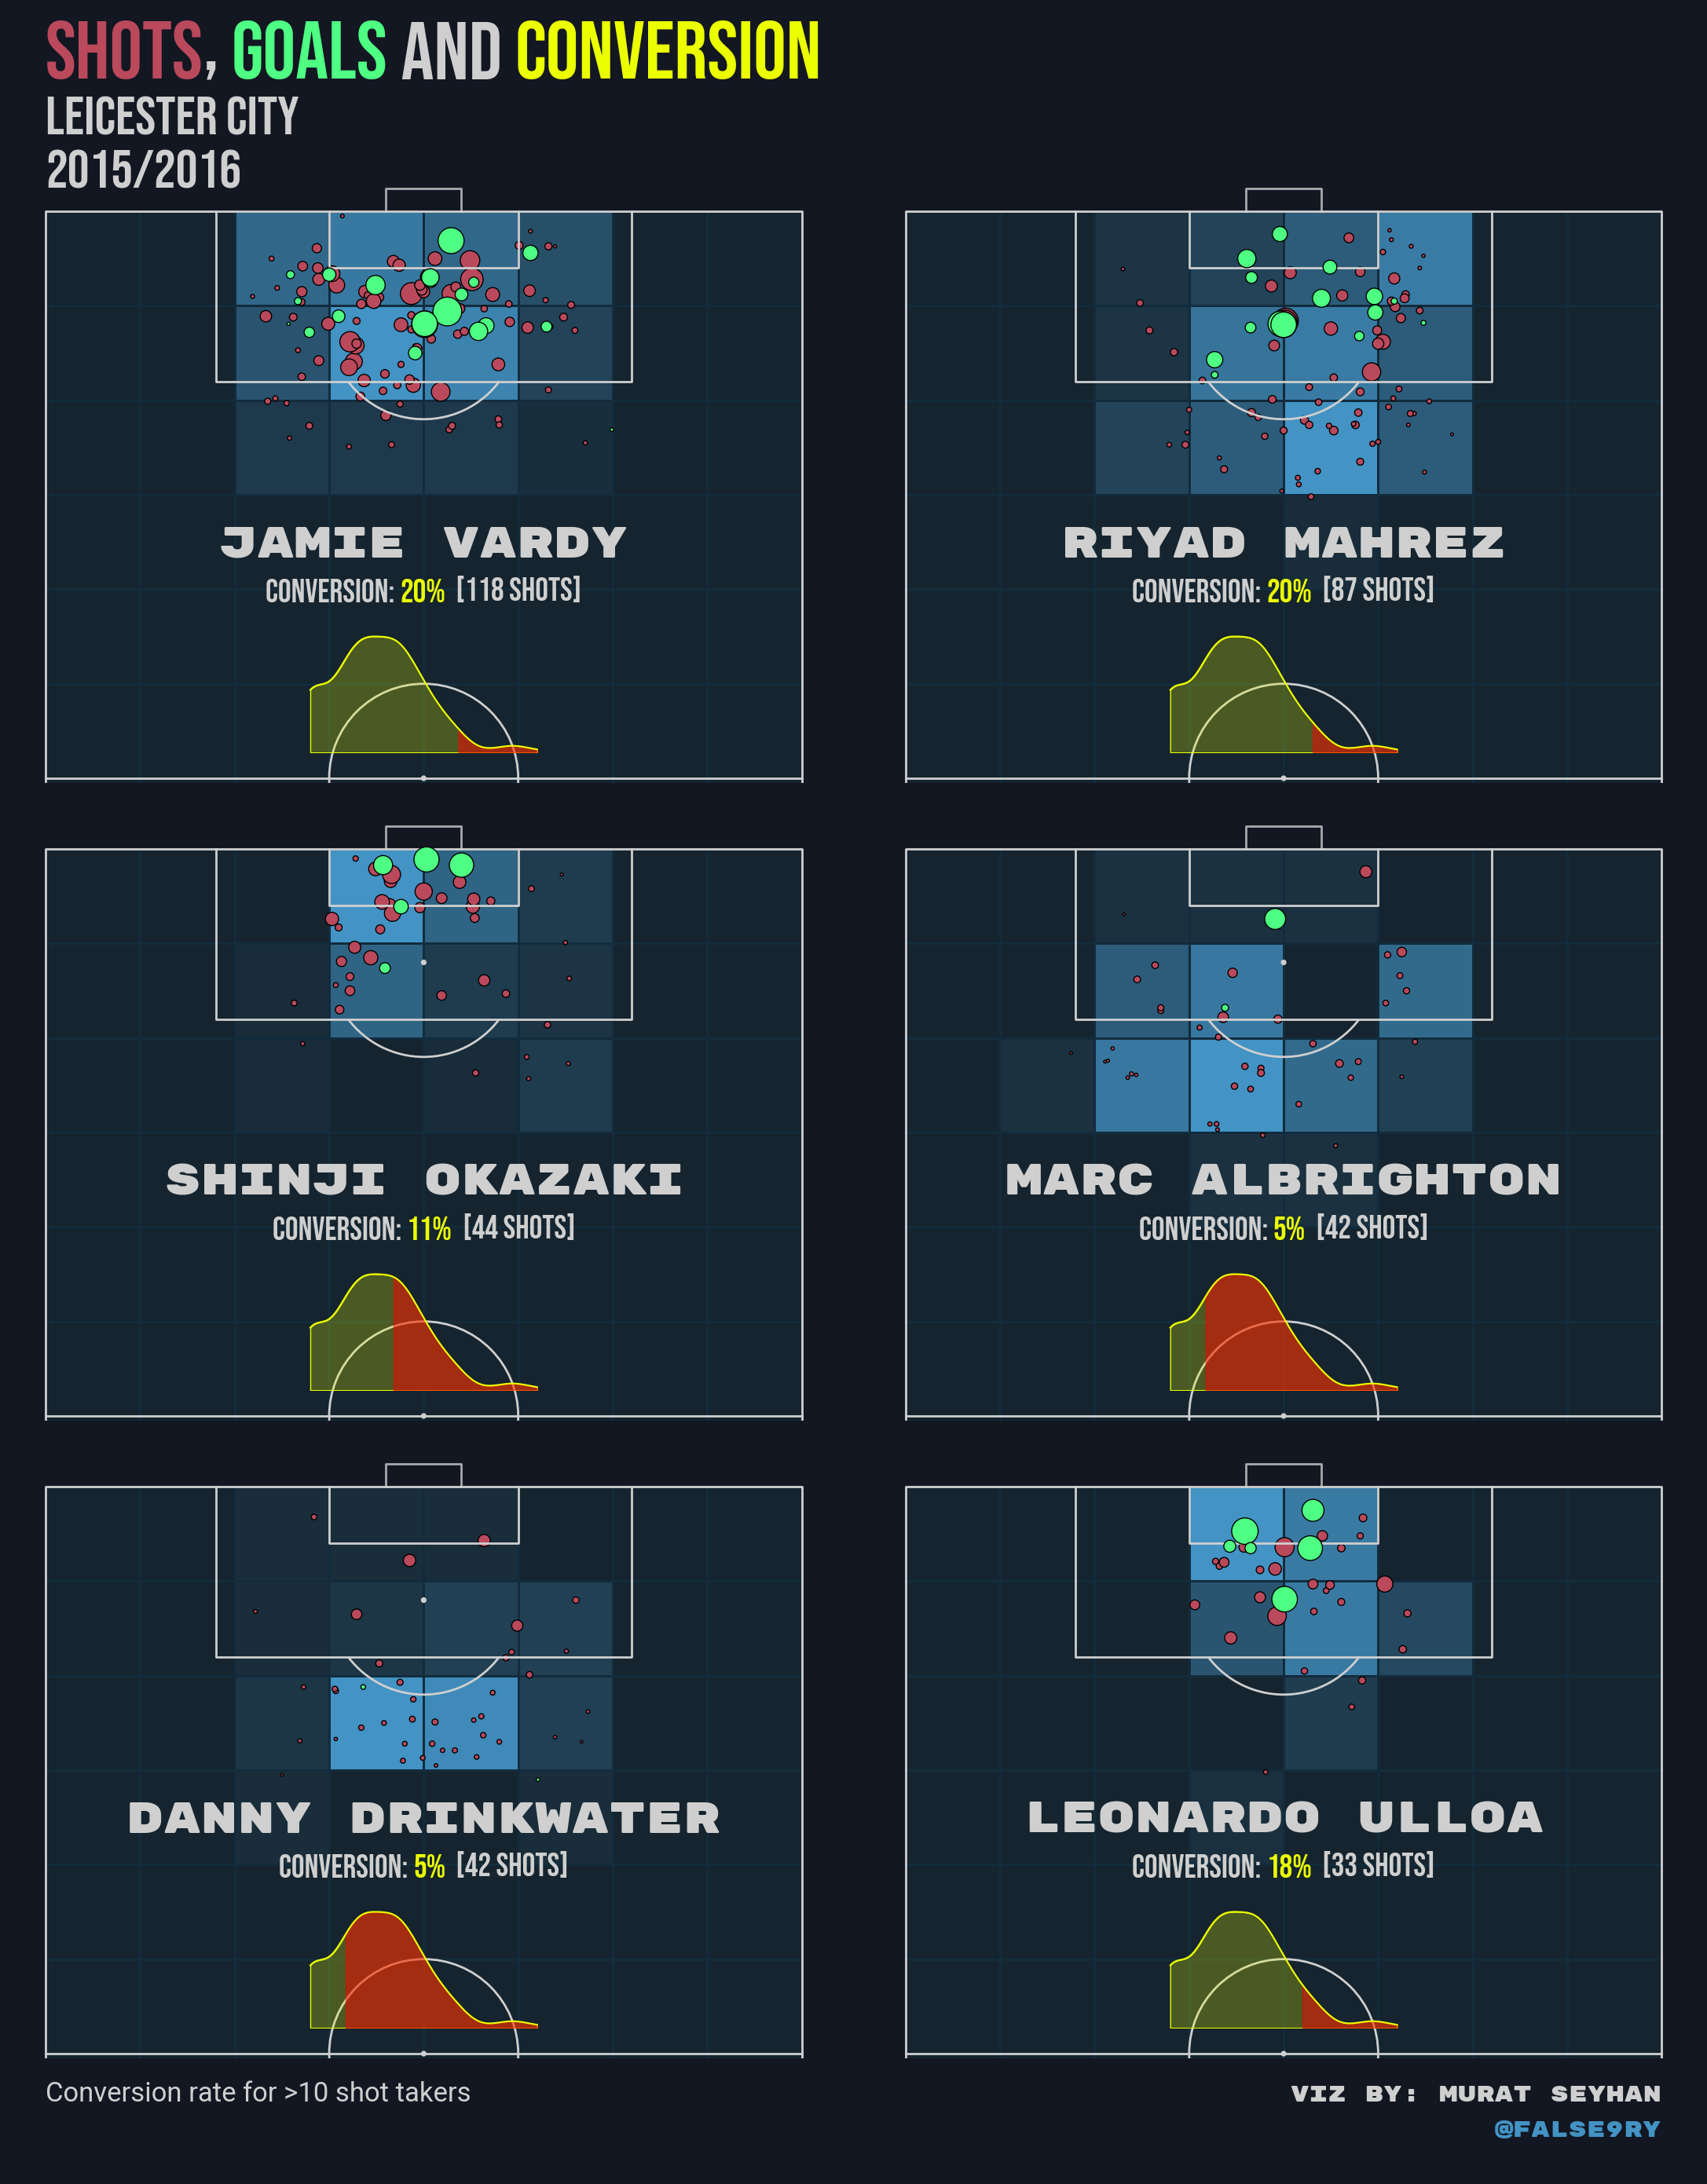

In [173]:
from scipy.stats import t
from scipy import stats
pitch = VerticalPitch(pad_bottom=0.5,
        half=True,
        goal_type='box',
        goal_alpha=0.8,
        line_zorder = 2,
        line_color='#cfcfcf',
        pitch_color = "#131722",
        pitch_type='statsbomb')

fig, axs = pitch.grid(nrows=3,
                        ncols=2,
                        grid_width=0.88,
                        left=0.025,
                        figheight=30,
                        endnote_height=0.05,
                        endnote_space=0,
                        axis=False,
                        title_space=0.01,
                        title_height=0.06,
                        grid_height=0.8,
                        space = 0.03)

analyzer = footyviz(df_event, pitch)
conversion_rates = analyzer.data[analyzer.data['type_name'] == 'Shot'].groupby('player_id')['outcome_name'].apply(lambda x: (x == 'Goal').mean())
conversion_rates = conversion_rates[analyzer.data[analyzer.data['type_name'] == 'Shot'].groupby('player_id')['outcome_name'].count() > 10]

analyzer.navigate(type_name='Shot',team_name_x='Leicester City')
# understand axes' grids and define them in variables.
grid_row_len = len(axs["pitch"]) # define grid's row count
grid_col_len = len(axs["pitch"][0]) # define grid's column count
grid_size = grid_row_len * grid_col_len # define grid size

fig.set_facecolor(analyzer.backgroundColor)

# get most shots based on grid size to fill all grids with players. defining grids will determine how many players it'll visualize
most_shots = analyzer.data.groupby("player_id").agg({"type_name":"count"}).sort_values(by="type_name",ascending=False).head(grid_size).index.tolist()
playerNameFm = FontManager(url=config["fonts"]["rubik"])
captionFm = FontManager(url=config["fonts"]["bebas_neue"])
nameTagFm = FontManager(url=config["fonts"]["roboto_regular"])


for i in [((index // grid_col_len), (index % grid_col_len), value) for index, value in enumerate(most_shots)]:
    playerData = analyzer.data[analyzer.data.player_id == i[2]]
    playerNick = playerData.player_nickname.iloc[0]
    teamName = playerData.team_name_x.iloc[0]
    bs = pitch.bin_statistic(playerData.x, playerData.y, bins=(12, 8))
    heatmap = pitch.heatmap(bs, 
                            edgecolors='#122c3d',
                            ax=axs["pitch"][i[0]][i[1]],
                            cmap=get_config_cmap("pearl_earring",n=100))
    goals = playerData[playerData.outcome_name == "Goal"]
    nogoals = playerData[playerData.outcome_name != "Goal"]
    conv_rate = len(goals) / len(playerData)
    shot_count = len(playerData)
    goals_scatty = pitch.scatter(goals.x, goals.y, s=goals.shot_statsbomb_xg * 700, zorder =3,
                        ec='black', color='#4EFF83',ax=axs["pitch"][i[0]][i[1]])
    others_scatty = pitch.scatter(nogoals.x, nogoals.y, s=nogoals.shot_statsbomb_xg * 700,
                        ec='black', color='#ba495c',ax=axs["pitch"][i[0]][i[1]])
    density_ax = axs["pitch"][i[0]][i[1]].inset_axes([0.35, 0.05, 0.3, 0.2])  # [x, y, width, height]
    density_ax.set_axis_off()
    kde_data = sns.kdeplot(conversion_rates,color="#EBFF01", cut=0,ax=density_ax).get_lines()[0].get_data()
    x_values, y_values = kde_data
    sns.kdeplot(conversion_rates, fill=True, color="#EBFF01",cut=0,ax=density_ax)
    density_ax.fill_between(x_values, 0, y_values, where=(x_values > conv_rate), color='red', alpha=0.5)
    density_ax.set_facecolor('none')
    ax_text(40, 85, 
            f'''{playerNick}''',
        ax=axs["pitch"][i[0]][i[1]],
        fontsize=40,
        va='center',
        ha='center',
        color = pitch.line_color,
        weight='bold',
        fontproperties=playerNameFm.prop
        ,zorder = 5)
    ax_text(40, 80, 
            f'''Conversion: <{conv_rate:.0%}>  [{len(playerData)} shots]''',
        ax=axs["pitch"][i[0]][i[1]],
        fontsize=30,
        va='center',
        ha='center',
        color = pitch.line_color,
        weight='bold',
        fontproperties=captionFm.prop
        , highlight_textprops=[{"color": '#EBFF01'}]
        ,zorder = 5)

ax_text(0, 0.5, 
        f'''<Shots>, <Goals> and <Conversion>''',
    ax=axs["title"],
    fontsize=75,
    va='bottom',
    ha='left',
    color = pitch.line_color,
    weight='bold',
    fontproperties=captionFm.prop
    , highlight_textprops=[{"color": '#BA495C'},{"color": '#4EFF83'},{"color": '#EBFF01'}]
    ,zorder = 5)

ax_text(0, 0.24,
        f'''{teamName}''',
    ax=axs["title"],
    fontsize=50,
    va='center',
    ha='left',
    color = pitch.line_color,
    weight='bold',
    fontproperties=captionFm.prop
    ,zorder = 5)

ax_text(0, 0, 
        f'''{analyzer.seasonNameList[0]}''',
    ax=axs["title"],
    fontsize=50,
    va='top',
    ha='left',
    color = pitch.line_color,
    weight='bold',
    fontproperties=captionFm.prop
    ,zorder = 5)

axs['endnote'].text(1, 0.4, '@false9ry',color="#4393c4" ,
                    va='center', ha='right', fontsize=20,
                    fontproperties=playerNameFm.prop)
axs['endnote'].text(1, 0.7, 'VIZ BY: MURAT SEYHAN', color=pitch.line_color,
                    va='center', ha='right', fontsize=20,
                    fontproperties=playerNameFm.prop)
axs['endnote'].text(0, 0.7, 'Conversion rate for >10 shot takers', color=pitch.line_color,
                    va='center', ha='left', fontsize=25,
                    fontproperties=nameTagFm.prop)